In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/rotation/16h5/s_yaw_16h5_2m_720_30.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,30.397384
1,0.316534,37.884915
2,0.982116,11.845627
3,1.309343,2.479181
4,1.939487,3.511144
...,...,...
909,101.317930,74.223443
910,101.418097,71.456404
911,101.515909,72.368710
912,101.625006,76.257898


<AxesSubplot:xlabel='relative_time'>

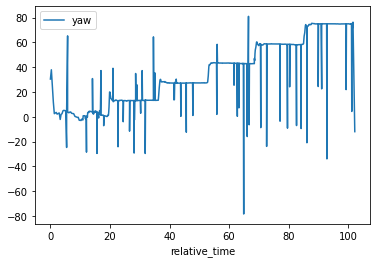

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

167

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

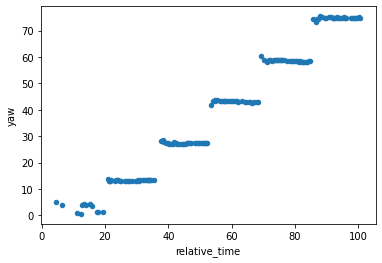

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)

In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [13]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [14]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.tail(2)

,relative_time,yaw,true_yaw,error
100,17.684919,1.417482,0,-1.417482
116,19.263358,1.216725,0,-1.216725
270,34.399703,13.272193,15,1.727807
282,35.508279,13.237695,15,1.762305
435,51.881130,27.250691,30,2.749309
439,52.305299,27.326145,30,2.673855
591,68.070622,42.923475,45,2.076525
593,68.275640,42.931411,45,2.068589
753,84.414460,58.310781,60,1.689219
756,84.713648,58.471917,60,1.528083


In [15]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,12.0,-2.866578,1.657439,-5.223641,-4.061532,-3.586290,-1.314326,-0.527130
15,30.0,1.745446,0.150157,1.318058,1.644165,1.753896,1.866319,1.953856
30,32.0,2.579743,0.332781,1.594584,2.586353,2.682894,2.763539,2.889025
45,28.0,1.836682,0.333247,1.368927,1.639055,1.727530,2.020718,3.043948
60,32.0,1.427648,0.442962,-0.395775,1.240021,1.432650,1.666693,2.084129
75,32.0,0.187845,0.388756,-0.380210,0.060311,0.081352,0.116058,1.941177


In [16]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

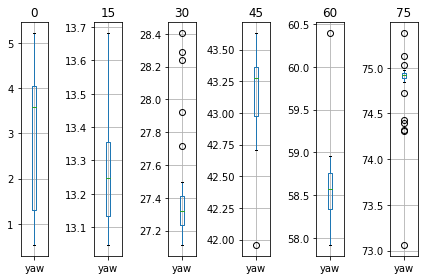

In [17]:
box_plotter(target)

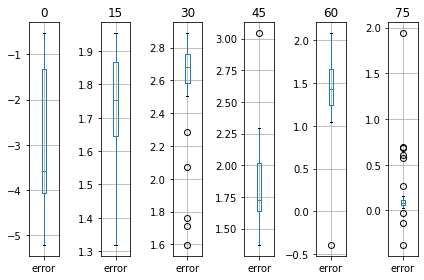

In [18]:
box_plotter('error')

In [19]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/rotations/result/csv/2m_16h5_720.csv')